# Section 1: Introduction
- The aim of the experiment is to train a DCGAN on the bitmoji dataset.
- Sample 1000 images using the trained generator and calculate the FID metric
- The dataset used can be accessed here: https://www.kaggle.com/datasets/mostafamozafari/bitmoji-faces 

# Section 2: Importing required libraries and dataset into VM 

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import glob
import random
import os
import numpy as np
import time
import sys
import datetime
import shutil
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path

from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [ ]:
train_dir=r'/home/bitmoji/train'
val_dir=r'/home/bitmoji/val'
save_dir=r'/home/bitmoji/saved_images'
model_save_path=r'/home/bitmoji/saved_models'

os.makedirs('/home/bitmoji',exist_ok=True)
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
os.makedirs(save_dir,exist_ok=True)
os.makedirs(model_save_path,exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /home/bitmoji_dataset.zip -d /home/bitmoji

In [5]:
all_files=[file_path for file_path in Path(r'/home/bitmoji/bitmojis').glob('*.png')]
# all_files=os.listdir(r'/content/bitmoji/bitmojis')

val_files = random.sample(all_files,1000)

for file in val_files:
  shutil.move(file.as_posix(),val_dir)

all_files=[file_path for file_path in Path(r'/home/bitmoji/bitmojis').glob('*.png')]
train_files=random.sample(all_files,len(all_files))

for file in train_files:
  shutil.move(file.as_posix(),train_dir)


print('Number of Training Images:',len(os.listdir(train_dir)))
print('Number of Validation Images:',len(os.listdir(val_dir)))

Number of Training Images: 129227
Number of Validation Images: 1000


# Section 3: setting main hyperparameters

In [5]:
img_size=64  # h,w of img
batch_size=1024
channels=3
latent_dim=100 
n_epochs=150
lr=0.0002
sample_interval=100 #sample at every 100 steps
checkpoint_interval =20 #checkpoint at every 20 epochs

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Section 4: Setting up torch dataloaders

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root_source, transforms_=None):
        
        self.transform = transforms.Compose(transforms_)
        self.files = sorted([img_path.as_posix() for img_path in Path(root_source).glob('*')])

    def __getitem__(self, index):

        img = Image.open(self.files[index])
        img = self.transform(img)  
        return img

    def __len__(self):
        return len(self.files)

In [7]:
# transforms_ = [
    
#     transforms.Resize((img_size,img_size), Image.BICUBIC),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ]
transforms_ = [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]

dataloader = DataLoader(
    ImageDataset(train_dir, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=6,
    pin_memory=True
)

val_dataloader = DataLoader(
    ImageDataset(val_dir, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=6,
    pin_memory=True
)

# Section 5: Defining the models

## Section 5.1: Defining the generator 

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        # print(self.init_size)
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        # print(out.shape)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


## Section 5.2: Defining the discriminator 

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

## Section 5.3: Initializing weights and importing model objects

In [12]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [13]:
generator = Generator()
discriminator = Discriminator()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

#Loss Functions
adversarial_loss = torch.nn.BCELoss()

#Converting them to CUDA
generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

BCELoss()

# Section 6: Model Training

Some details about model training
- The discriminator is trained 2 times for every 1 time the generator is trained in hopes that a good discriminator will lead to better sampling
- The experiment is trained for 150 epochs with a multistep LOR reduction for better tuning
- A letent dimension of 100 is used

In [14]:
def train_generator(imgs,valid):
  
    optimizer_G.zero_grad()

    # Sample noise as generator input
    z = torch.randn(imgs.shape[0],latent_dim).to(device)

    # Generate a batch of images
    gen_imgs = generator(z)

    # Loss measures generator's ability to fool the discriminator
    g_loss = adversarial_loss(discriminator(gen_imgs), valid)

    g_loss.backward()
    optimizer_G.step()

    return g_loss,gen_imgs


def train_discriminator(real_img,gen_imgs,valid,fake):
    optimizer_D.zero_grad()

    # Measure discriminator's ability to classify real from generated samples
    real_loss = adversarial_loss(discriminator(real_img), valid)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()
    
    return d_loss




In [15]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

scheduler_G = torch.optim.lr_scheduler.MultiStepLR(optimizer_G, milestones=[50,75,125],gamma=0.4)
scheduler_D = torch.optim.lr_scheduler.MultiStepLR(optimizer_D, milestones=[50,75,125],gamma=0.4)

prev_time = time.time()

g_losses=[]
d_losses=[]

for epoch in range(n_epochs):
    
    for i, imgs in enumerate(dataloader):
        
        real_img=imgs.to(device)

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0),1,device=device)
        fake  = torch.zeros(imgs.size(0),1,device=device)

        # -----------------
        #  Train Generator
        # -----------------
        g_loss,gen_imgs = train_generator(imgs,valid)
        

        # ---------------------
        #  Train Discriminator
        # ---------------------
        d_loss=train_discriminator(real_img,gen_imgs,valid,fake)
        d_loss=train_discriminator(real_img,gen_imgs,valid,fake)
        
  
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]  ETA: %s"
          % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item(),time_left)
        )
        
        if batches_done % sample_interval == 0:
          save_image(gen_imgs.data[:100], Path(save_dir,'{0}.png'.format(batches_done)).as_posix(), nrow=10, normalize=True)

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    scheduler_G.step()
    scheduler_D.step()

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
      # Save model checkpoints
      torch.save(generator.state_dict(), Path(model_save_path,'bitmoji_generator_{0}.pth'.format(epoch)).as_posix())
      torch.save(discriminator.state_dict(), Path(model_save_path,'bitmoji_discriminator_{0}.pth'.format(epoch)).as_posix())

[Epoch 149/150] [Batch 126/127] [D loss: 0.520582] [G loss: 0.597972]  ETA: 0:00:00.511901

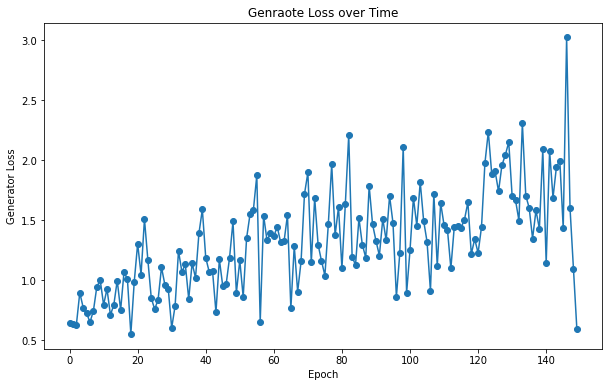

In [16]:
x=range(len(g_losses))

plt.figure(figsize=(10,6))
plt.plot(x,g_losses ,'-')
plt.scatter(x,g_losses)
plt.xlabel('Epoch')
plt.ylabel('Generator Loss')
plt.title('Genraote Loss over Time')
plt.show()


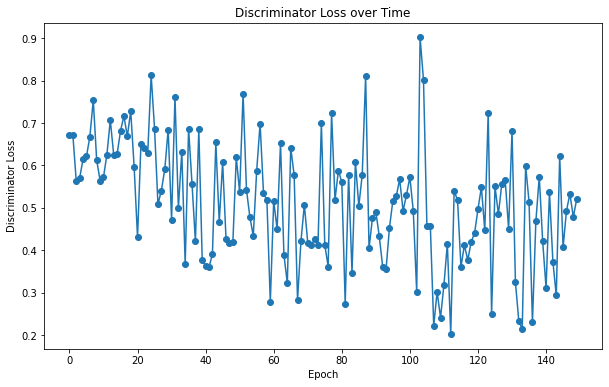

In [17]:
x=range(len(d_losses))

plt.figure(figsize=(10,6))
plt.plot(x,d_losses ,'-')
plt.scatter(x,d_losses)
plt.xlabel('Epoch')
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Loss over Time')
plt.show()


## Section 6.2: Observations from training
- It can be observed the training is not fully stabilized yet which can be observed from the fluctuating D_loss and G_loss
- Training for more epochs or using a more complex Generative network might be more helpful 
 

# Section 7: creating a video of generated samples during training

**The video can be found here: https://youtube.com/shorts/QXhOsPC2CJE**

In [3]:
import cv2
import os

image_folder = r'D:\pytorch-zero to gans\dcgan\saved_images'
video_name = r'D:\pytorch-zero to gans\dcgan\gans_training.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 4, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

# Section 8: Inference (i.e) Generating image from Latent space

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
generator = Generator()
generator.to(device)
generator.load_state_dict(torch.load(r'bitmoji_generator_140.pth'))

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return images * stds + means

stats = ([0.5,0.5,0.5], [0.5,0.5,0.5])

<All keys matched successfully>

In [26]:
z = torch.randn(1,latent_dim).to(device)
gen_imgs = generator(z)
out=denormalize(gen_imgs, *stats)
out=out.squeeze(0)
x=transforms.ToPILImage()(out)

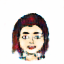

In [27]:
x

# Section 9: Calculating FID metric for 1000 generated images

In [25]:

os.makedirs(r'generated_images',exist_ok=True)


for i in range(100):
    z = torch.randn(1,latent_dim).to(device)
    gen_imgs = generator(z)
    out=denormalize(gen_imgs, *stats)
    out=out.squeeze(0)
    x=transforms.ToPILImage()(out)
    x.save(r'generated_images/image_{}.png'.format(str(i)))
    

In [28]:
!pip install pytorch-fid


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [29]:
!python -m pytorch_fid generated_images/ val/

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████████████████████████████████| 91.2M/91.2M [00:07<00:00, 13.0MB/s]
100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  6.78it/s]
FID:  192.81525894572738


# Section 10: Final Conclusions
1. A DCGAN was trained, however a good stable tarining was difficult to obtain
2. The generated images from tarining can be accessed here: https://www.youtube.com/shorts/QXhOsPC2CJE
3. The FID metric for generated 1000 images and images from validation dataset was found to be 192.8 